In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from carps.analysis.process_data import get_interpolated_performance_df, load_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


rundir = "../runs"

df, df_cfg = load_logs(rundir=rundir)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")

[16:50:04] INFO     Load logs from `../runs/logs.csv` and associated configs from               ]8;id=357339;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=637336;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#156\156]8;;\
                    ../runs/logs_cfg.csv. Preprocess logs.                                                         

/home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py:162: DtypeWarning: Columns (7,9,19,21,27,28,29,32,33,34,35,36,42,43,44,45,46,47,48,49,52,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(logs_fn)


[16:50:24] INFO     Processing raw logs. Normalize n_trials and costs. Calculate trajectory      ]8;id=607385;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=859375;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#66\66]8;;\
                    (incumbent cost).                                                                              

Index(['n_trials', 'n_function_calls', 'trial_info__config',
       'trial_info__instance', 'trial_info__seed', 'trial_info__budget',
       'trial_info__normalized_budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.model',
       'problem.task_id', 'problem.budget_type', 'problem.seed',
       'task.n_trials', 'task.time_budget', 'task.n_workers',
       'task.n_objectives', 'task.objectives', 'task.is_multifidelity',
       'task.fidelity_type', 'task.min_budget', 'task.max_budget',
       'task.has_constraints', 'task.domain',
       'task.objective_function_approximation', 'task.has_virtual_time',
       'task.deterministic', 'task.dimensions',
       'task.search_space_n_categoricals', 'task.search_space_n_ordinals',
       'task.search_space_n_i

[16:52:03] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating       ]8;id=489284;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=981131;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#126\126]8;;\
                    budget.                                                                                        

[16:52:13] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating       ]8;id=669828;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=639563;file:///home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#126\126]8;;\
                    budget.                                                                                        

In [11]:
ids = (df["scenario"] == "multi-fidelity") & (df["benchmark_id"] == "HPOBench")
ids_ = (perf["scenario"] == "multi-fidelity") & (perf["benchmark_id"] == "HPOBench")
df = df[ids]
df_cfg = df_cfg[ids]
perf = perf[ids_]

/tmp/ipykernel_83848/3847473004.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cfg = df_cfg[ids]
/tmp/ipykernel_83848/3847473004.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  perf = perf[ids]


AssertionError: 47238, 1514971

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# ax = sns.lineplot(data=perf, x="n_trials_norm", y="trial_value__cost_inc_norm", style="seed", hue="problem_id")
# ax.get_legend().remove()
# plt.show()

In [4]:
import tsfel
from functools import partial
from multiprocessing import Pool

cfg_file = tsfel.get_features_by_domain()               # All features will be extracted.
cgf_file = tsfel.get_features_by_domain("statistical")  # All statistical domain features will be extracted
# cgf_file = tsfel.get_features_by_domain("temporal")     # All temporal domain features will be extracted
# cgf_file = tsfel.get_features_by_domain("spectral") 

window_size = 21
groups = list(perf.groupby(by=["optimizer_id", "problem_id", "seed"])["trial_value__cost_inc_norm"])
gids = [g[0] for g in groups]
signal_windows = list([g[1].to_numpy() for g in groups])
signal_windows = np.array([s for s in signal_windows if len(s) == 21])
# signal_windows = pd.DataFrame(signal_windows)
print(signal_windows.shape)
# print(set([len(s) for s in signal_windows]))
# print(signal_windows)

def extract(signal_windows):
    return tsfel.time_series_features_extractor(
        dict_features=cfg_file, 
        signal_windows=signal_windows, 
        fs=None, 
        window_size=window_size, 
        verbose=0,
        n_jobs=None
        )

with Pool(processes=4) as pool:
    X_train = pool.map(extract, signal_windows)

X_train = np.concatenate(X_train)
X_train.shape

(2249, 21)


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/home/numina/micromamba/envs/carpsexp/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.kurtosis(signal)
/home/numina/micromamba/envs/carpsexp/lib/python3.11/site-packages/tsfel/feature_extraction/features.py:550: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return scipy.stats.skew(signal)
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(
/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


/tmp/ipykernel_83848/122137791.py:21: UserWarning: Using default sampling frequency set in configuration file.
  return tsfel.time_series_features_extractor(


(2249, 144)

In [5]:
pd.DataFrame(X_train).to_csv("tsfeatures.csv")

In [7]:
perf["benchmark_id"].unique()

array(['HPOBench', 'MFPBench', 'YAHPO'], dtype=object)

True
(2249, 2)
(20, 2)
[['SyneTune-ASHA' 'mfpbench/mfh/mfh6_terrible' '4']
 ['RandomSearch' 'mfpbench/pd1/imagenet_resnet_512' '8']
 ['SMAC3-1.4-MultiFidelityFacade'
  'yahpo/multifidelity/so/trainsize/rbv2_ranger/16/trainsize' '7']
 ['SMAC3-1.4-MultiFidelityFacade' 'mfpbench/mfh/mfh6_good' '5']
 ['SyneTune-DEHB' 'mfpbench/pd1/cifar100_wideresnet_2048' '10']
 ['RandomSearch' 'mfpbench/pd1/lm1b_transformer_2048' '4']
 ['SMAC3-1.4-MultiFidelityFacade'
  'yahpo/multifidelity/so/epoch/nb301/CIFAR10/epoch' '2']
 ['SMAC3-1.4-MultiFidelityFacade'
  'yahpo/multifidelity/so/trainsize/rbv2_xgboost/1501/trainsize' '7']
 ['SMAC3-1.4-MultiFidelityFacade'
  'yahpo/multifidelity/so/trainsize/rbv2_rpart/40499/trainsize' '6']
 ['SMAC3-1.4-MultiFidelityFacade'
  'yahpo/multifidelity/so/trainsize/rbv2_super/1468/trainsize' '9']
 ['SMAC3-1.4-MultiFidelityFacade' 'mfpbench/pd1/lm1b_transformer_2048'
  '1']
 ['RandomSearch' 'yahpo/multifidelity/so/repl/rbv2_rpart/14/repl' '3']
 ['RandomSearch' 'yahpo/multif

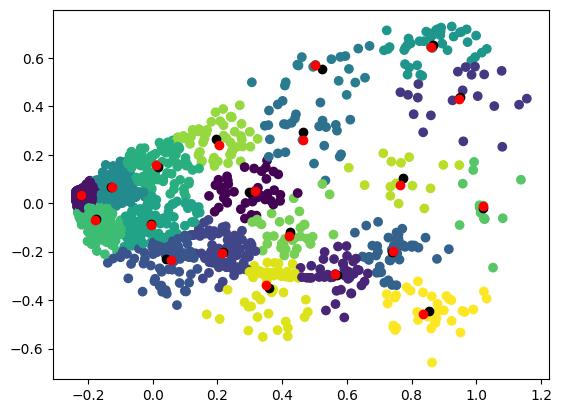

In [6]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

n_clusters = 20

print(np.any(np.isnan(X_train)))

X_clean = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train)
X_clean = normalize(X_clean)

X_pca = PCA(n_components=2).fit_transform(X_clean)

print(X_pca.shape)

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X_pca)
clusters = kmeans.predict(X_pca)

centers = kmeans.cluster_centers_
print(centers.shape)

def idx_min_dist_to_center(P, c):
    D = np.sum((P - c) ** 2, axis=1)
    return np.argmin(D)


ids = [idx_min_dist_to_center(X_pca, c) for c in centers]
closest_points = X_pca[ids]
print(np.array(gids)[ids])

fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
ax.scatter(centers[:, 0], centers[:, 1], color="black")
ax.scatter(closest_points[:, 0], closest_points[:, 1], color="red")
plt.show()